In [1]:
def load_text(path):
    texts = []
    labels =[]
    with open(path,'r') as file:
        txts = [x.split(';') for x in file.readlines()]
        for text,label in txts:
            texts.append(text)
            labels.append(label.rstrip('\n'))
    return texts,labels

In [2]:
train_path = '../data/emotion/train.txt'
test_path = '../data/emotion/test.txt'
val_path = '../data/emotion/val.txt'

In [3]:
X_train, y_train = load_text(train_path)
X_val, y_val = load_text(val_path)
X_test, y_test = load_text(test_path)

In [80]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, RNN, LSTM, SimpleRNN, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [125]:
from tensorflow.keras.models import Sequential

In [110]:
from tensorflow.keras.callbacks import EarlyStopping

# Preparing

In [40]:
def preprocess_texts(txts):
    preprocessed_texts = []
    stop_words = set(stopwords.words('english'))
    for txt in txts:
        words = word_tokenize(txt)
        filtered_txt = [word for word in words if word.lower() not in stop_words and word not in string.punctuation]
        txt = ' '.join(filtered_txt)
        preprocessed_texts.append(txt)
    preprocessed_texts = np.array(preprocessed_texts)
    return preprocessed_texts

In [46]:
def get_encoder(label):
    label_reshaped = np.array(label).reshape(-1, 1)
    encoder = LabelEncoder()
    encoder = encoder.fit(label_reshaped)
    return encoder

In [35]:
def train_word2vec(sentences, vector_size=100):
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=5, min_count=1)
    return model

In [71]:
def prepare_data(sentences, labels, w2v_model, label_encoder, max_len=50):
    # Convert sentences to sequences
    sequences = [np.array([w2v_model.wv[word] for word in sent]) for sent in sentences]
    vectors = pad_sequences(sequences, maxlen=max_len, padding='post')
    # if vectors:
    #     vectors = np.mean(vectors, axis=0)
    # Encode labels
    label_reshaped = np.array(labels).reshape(-1, 1)
    encoded_labels = label_encoder.transform(label_reshaped)
    y = to_categorical(encoded_labels)
    
    return vectors, y

In [86]:
def build_rnn_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(128, return_sequences=True)(inputs)
    x = SimpleRNN(64)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [81]:
# def build_lstm_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
#     x = LSTM(128, return_sequences=True)(inputs)
#     x = LSTM(64)(x)
#     x = Dense(32, activation='relu')(x)
#     x = Dropout(0.3)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     model = Model(inputs, outputs)
#     model.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])
#     return model

In [129]:
def build_lstm_model(maxlen=50, vector_size=100, num_classes=6):
    model = Sequential([
        Input(shape=(maxlen, vector_size)),  # For Word2Vec vectors
        LSTM(64),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [41]:
# preprocessing
X_train_p = preprocess_texts(X_train)
X_train_p

array(['didnt feel humiliated',
       'go feeling hopeless damned hopeful around someone cares awake',
       'im grabbing minute post feel greedy wrong', ...,
       'feel strong good overall', 'feel like rude comment im glad',
       'know lot feel stupid portray'], dtype='<U232')

In [122]:
maxlen =  max(len(sentence) for sentence in X_train_p)

In [123]:
maxlen

232

In [42]:
X_val_p = preprocess_texts(X_val)
X_test_p = preprocess_texts(X_test)

In [47]:
encoder = get_encoder(y_train)

/Users/aayamojha/DWIT-TC/data_science_ml/lesson_3/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
w2v_model = train_word2vec(X_train_p, vector_size=100)

In [72]:
X_train_vec, y_train_en = prepare_data(X_train_p, y_train, w2v_model, encoder)

/Users/aayamojha/DWIT-TC/data_science_ml/lesson_3/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [73]:
X_train_vec

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [74]:
X_train_vec.shape

(16000, 50, 100)

In [75]:
input_shape = (X_train_vec.shape[1], X_train_vec.shape[2])
input_shape

(50, 100)

In [76]:
y_train_en.shape

(16000, 6)

## Validation Set

In [91]:
X_val_vec, y_val_en = prepare_data(X_val_p, y_val, w2v_model, encoder)

/Users/aayamojha/DWIT-TC/data_science_ml/lesson_3/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [87]:
model_rnn = build_rnn_model(input_shape)

In [88]:
model_rnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 50, 128)        │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,942 (171.65 KB)

 Trainable params: 43,942 (171.65 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min' ,restore_best_weights=True)

In [108]:
EPOCHS = 150
BATCH_SIZE = 512

In [112]:
history = model_rnn.fit(X_train_vec, y_train_en, 
                        validation_data=(X_val_vec, y_val_en), epochs=EPOCHS, batch_size=BATCH_SIZE,
                       callbacks=[early_stopping])

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step - accuracy: 0.3300 - loss: 0.4122 - val_accuracy: 0.3520 - val_loss: 0.4082
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.3430 - loss: 0.4096 - val_accuracy: 0.3520 - val_loss: 0.4081
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.3329 - loss: 0.4124 - val_accuracy: 0.3520 - val_loss: 0.4082
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - accuracy: 0.3365 - loss: 0.4106 - val_accuracy: 0.3520 - val_loss: 0.4082
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.3329 - loss: 0.4134 - val_accuracy: 0.3520 - val_loss: 0.4081
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.3322 - loss: 0.4126 - val_accuracy: 0.3520 - val_loss: 0.4081
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.3339 - loss: 0.4115 - val_accuracy: 0.3520 - val_loss: 0.4081
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.3297 - loss: 0.4144 - val_ac

In [113]:
import matplotlib.pyplot as plt

In [115]:
def plot(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], label='Training Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    axs[1].plot(history.history['loss'], label='Training Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()

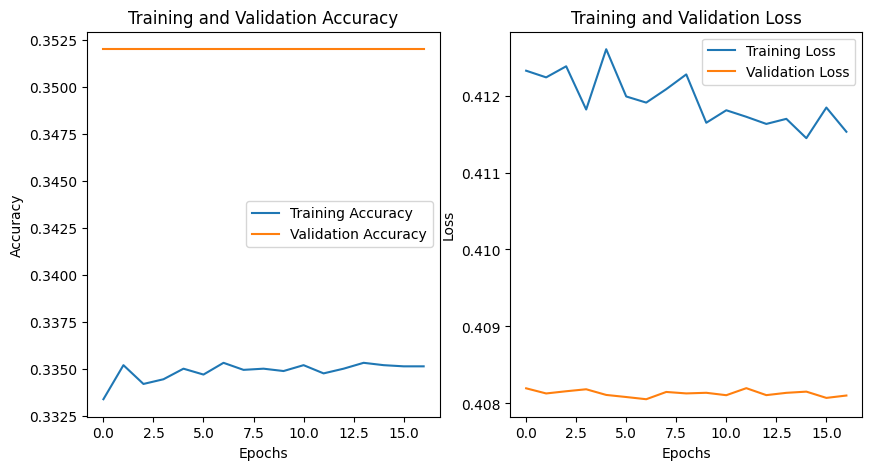

In [116]:
plot(history)

In [130]:
model_lstm = build_lstm_model()

In [131]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,518 (173.90 KB)

 Trainable params: 44,518 (173.90 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
history = model_lstm.fit(X_train_vec, y_train_en, 
                        validation_data=(X_val_vec, y_val_en), epochs=EPOCHS, batch_size=BATCH_SIZE,
                       callbacks=[early_stopping])

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.3276 - loss: 1.5973 - val_accuracy: 0.3520 - val_loss: 1.5858
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.3295 - loss: 1.6013 - val_accuracy: 0.3520 - val_loss: 1.5857
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.3233 - loss: 1.5948 - val_accuracy: 0.3520 - val_loss: 1.5833
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.3235 - loss: 1.5981 - val_accuracy: 0.3520 - val_loss: 1.5807
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.3247 - loss: 1.5901 - val_accuracy: 0.3520 - val_loss: 1.5825
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.3277 - loss: 1.5891 - val_accuracy: 0.3520 - val_loss: 1.5808
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.3263 - loss: 1.5938 - val_accuracy: 0.3520 - val_loss: 1.5811
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.3200 - loss: 1.5879 - val_acc

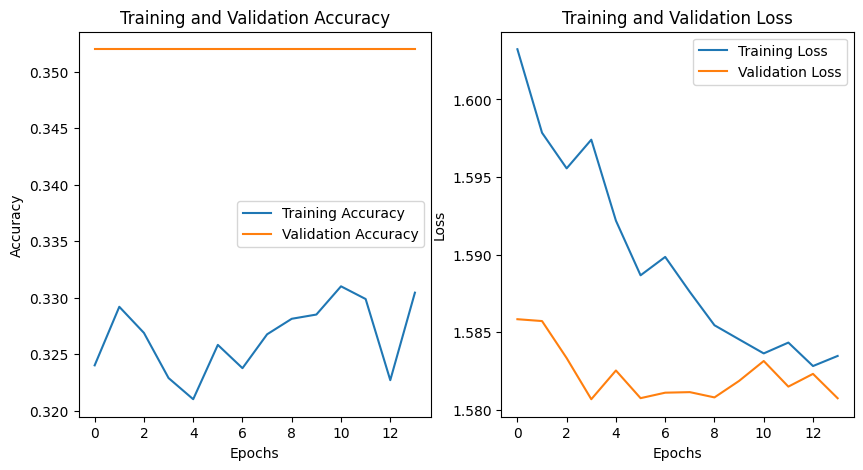

In [135]:
plot(history)